In [4]:
import numpy as np

bigram_count_dict = {}

MODE='eos'
for ds_version in ['cc_8k', 'cc_merged_v1_8k', 'cc_merged_v2_8k', 'cc_merged_v3_8k']:
    bigram_count_dict[ds_version] = np.load(f"/home/aiops/zhuty/tinyllama/processing/corpus_analysis/{ds_version}_{MODE}_counts.npy")
    assert bigram_count_dict[ds_version].shape == (100000,), bigram_count_dict[ds_version].shape


In [5]:
new_name_to_old_name = {
    'baseline': 'cc_8k',
    'dense': 'cc_merged_v1_8k',
    'bm25': 'cc_merged_v2_8k',
    'gen+bm25': 'cc_merged_v3_8k'

}

for new_name, old_name in new_name_to_old_name.items():
    if old_name in bigram_count_dict:
        bigram_count_dict[new_name] = bigram_count_dict.pop(old_name)

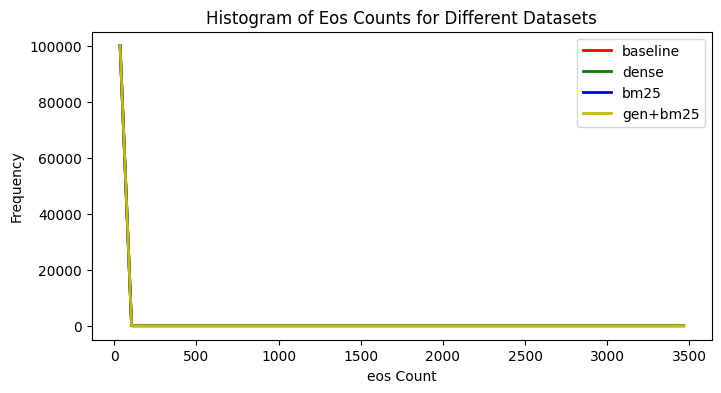

In [6]:
# plot the historgram of bigram counts with different colors
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# colors = ['r', 'g', 'b','y']  # Colors for different datasets
# for i, (dataset_name, counts) in enumerate(bigram_count_dict.items()):
#     plt.hist(counts, bins=100, range=(0, 8000), alpha=0.5, label=dataset_name, color=colors[i])
colors = ['r', 'g', 'b', 'y']  # Colors for different datasets

# Assuming bigram_count_dict is your data dictionary
for i, (dataset_name, counts) in enumerate(bigram_count_dict.items()):
    # Calculate the histogram data
    counts, bin_edges = np.histogram(counts, bins=50, range=(0, 3500))
    # Calculate bin centers instead of edges for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Plot using a line plot
    plt.plot(bin_centers, counts, label=dataset_name, color=colors[i], linestyle='-', linewidth=2)

# plt.legend()
# plt.show()

plt.title(f'Histogram of {MODE.lower().capitalize()} Counts for Different Datasets')
plt.xlabel(f'{MODE} Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

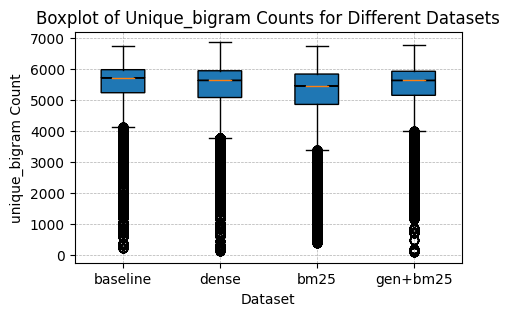

In [23]:
# Data preparation
datasets = list(bigram_count_dict.keys())
data = [bigram_count_dict[dataset] for dataset in datasets]

# Plotting
plt.figure(figsize=(5, 3))
plt.boxplot(data, notch=True, patch_artist=True)
plt.xticks(range(1, len(bigram_count_dict)+1), datasets)
plt.title(f'Boxplot of {MODE.lower().capitalize()} Counts for Different Datasets')
plt.xlabel('Dataset')
plt.ylabel(f'{MODE} Count')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# number of docs dict


## Get the correlation between eos count and terms count

In [15]:
MODE='eos'
eos_count_dict = {}
bigram_count_dict = {}
terms_count_dict = {}
for ds_version in ['cc_8k', 'cc_merged_v1_8k', 'cc_merged_v2_8k',  'cc_merged_v3_8k']:
    eos_count_dict[ds_version] = np.load(f"/home/aiops/zhuty/tinyllama/processing/corpus_analysis/{ds_version}_{MODE}_counts.npy")
    bigram_count_dict[ds_version] = np.load(f"/home/aiops/zhuty/tinyllama/processing/corpus_analysis/{ds_version}_unique_bigram_counts.npy")
    terms_count_dict[ds_version] = np.load(f"/home/aiops/zhuty/tinyllama/processing/corpus_analysis/{ds_version}_unique_terms_counts.npy")
    assert bigram_count_dict[ds_version].shape == (100000,), bigram_count_dict[ds_version].shape
    assert terms_count_dict[ds_version].shape == (100000,), terms_count_dict[ds_version].shape
    assert eos_count_dict[ds_version].shape == (100000,), eos_count_dict[ds_version].shape

In [16]:
new_name_to_old_name = {
    'baseline': 'cc_8k',
    'dense': 'cc_merged_v1_8k',
    'bm25': 'cc_merged_v2_8k',
    'gen+bm25': 'cc_merged_v3_8k'

}

In [17]:
for new_name, old_name in new_name_to_old_name.items():
    if old_name in eos_count_dict:
        eos_count_dict[new_name] = eos_count_dict.pop(old_name)
        bigram_count_dict[new_name] = bigram_count_dict.pop(old_name)
        terms_count_dict[new_name] = terms_count_dict.pop(old_name)

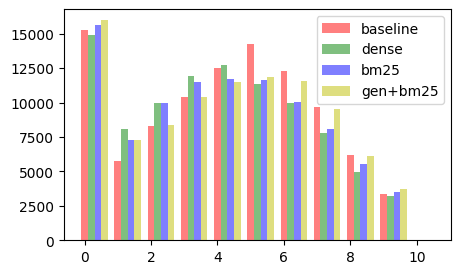

In [18]:
# Data preparation
datasets = list(eos_count_dict.keys())
data = [eos_count_dict[dataset] for dataset in datasets]
data2 = [bigram_count_dict[dataset] for dataset in datasets]
data3 = [terms_count_dict[dataset] for dataset in datasets]

# Plotting
plt.figure(figsize=(5, 3))
# plot the EOS count histogram, each dataset has a different color, each bin has different bars side by side
colors = ['r', 'g', 'b', 'y']  # Colors for different datasets
width = 0.2  # Width of each bar, adjust as necessary
bins = np.arange(0, 10, 0.1)  # Define bins for histogram

for i, (dataset_name, counts) in enumerate(eos_count_dict.items()):
    # Offset bins for each dataset
    offset_bins = bins + (i * width)
    # Use bar instead of hist for manual histogram with side-by-side bars
    hist, bin_edges = np.histogram(counts, bins=bins, range=(0, 10))
    plt.bar(bin_edges[:-1] + (i * width), hist, width=width, alpha=0.5, label=dataset_name, color=colors[i])

plt.legend()
plt.show()

In [26]:
from scipy.stats import mannwhitneyu
import itertools
from scipy.stats import ks_2samp

# Generate all unique pairs of datasets for comparison
dataset_pairs = list(itertools.combinations(eos_count_dict.keys(), 2))

# Perform Mann-Whitney U Test for each pair
for dataset1, dataset2 in dataset_pairs:
    stat, p = mannwhitneyu(eos_count_dict[dataset1], eos_count_dict[dataset2], alternative='two-sided')
    print(f"Comparison between {dataset1} and {dataset2}: U-statistic = {stat:.3f}, p-value = {p:.3f}")

    # Interpret the significance
    alpha = 0.05  # Set the significance level
    if p < alpha:
        print(f"--> The distributions of {dataset1} and {dataset2} are significantly different.")
    else:
        print(f"--> There is no significant difference between the distributions of {dataset1} and {dataset2}.")

    stat, p = ks_2samp(eos_count_dict[dataset1], eos_count_dict[dataset2])
    print(f"KS Test between {dataset1} and {dataset2}: Statistic = {stat:.3f}, p-value = {p:.3f}")

Comparison between baseline and dense: U-statistic = 5170059969.000, p-value = 0.000
--> The distributions of baseline and dense are significantly different.
KS Test between baseline and dense: Statistic = 0.053, p-value = 0.000
Comparison between baseline and bm25: U-statistic = 5115543930.500, p-value = 0.000
--> The distributions of baseline and bm25 are significantly different.
KS Test between baseline and bm25: Statistic = 0.046, p-value = 0.000
Comparison between dense and bm25: U-statistic = 4954729171.000, p-value = 0.000
--> The distributions of dense and bm25 are significantly different.
KS Test between dense and bm25: Statistic = 0.015, p-value = 0.000


In [28]:
eos_count_dict['baseline'][0:10]

array([5, 4, 4, 6, 2, 2, 3, 3, 0, 4])

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau

print(f"{'Dataset':<20} {'Comparison':<30} {'Correlation Type':<20} {'Value':<15} {'p-value':<15}")
print("-" * 100)

for dataset in datasets:
    # Pearson correlations
    eos_terms_pearson = pearsonr(eos_count_dict[dataset], terms_count_dict[dataset])
    eos_bigram_pearson = pearsonr(eos_count_dict[dataset], bigram_count_dict[dataset])
    terms_bigram_pearson = pearsonr(terms_count_dict[dataset], bigram_count_dict[dataset])

    # Kendall's tau correlations
    eos_terms_kendall = kendalltau(eos_count_dict[dataset], terms_count_dict[dataset])
    eos_bigram_kendall = kendalltau(eos_count_dict[dataset], bigram_count_dict[dataset])
    terms_bigram_kendall = kendalltau(terms_count_dict[dataset], bigram_count_dict[dataset])

    # Printing Pearson results
    print(f"{dataset:<20} {'EOS vs Terms':<30} {'Pearson':<20} {eos_terms_pearson[0]:<15.3f} {eos_terms_pearson[1]:<15.3f}")
    print(f"{dataset:<20} {'EOS vs Bigrams':<30} {'Pearson':<20} {eos_bigram_pearson[0]:<15.3f} {eos_bigram_pearson[1]:<15.3f}")
    print(f"{dataset:<20} {'Terms vs Bigrams':<30} {'Pearson':<20} {terms_bigram_pearson[0]:<15.3f} {terms_bigram_pearson[1]:<15.3f}")

    # Printing Kendall's tau results
    print(f"{dataset:<20} {'EOS vs Terms':<30} {'Kendall’s tau':<20} {eos_terms_kendall[0]:<15.3f} {eos_terms_kendall[1]:<15.3f}")
    print(f"{dataset:<20} {'EOS vs Bigrams':<30} {'Kendall’s tau':<20} {eos_bigram_kendall[0]:<15.3f} {eos_bigram_kendall[1]:<15.3f}")
    print(f"{dataset:<20} {'Terms vs Bigrams':<30} {'Kendall’s tau':<20} {terms_bigram_kendall[0]:<15.3f} {terms_bigram_kendall[1]:<15.3f}")

    print("-" * 100)


Dataset              Comparison                     Correlation Type     Value           p-value        
----------------------------------------------------------------------------------------------------
baseline             EOS vs Terms                   Pearson              0.583           0.000          
baseline             EOS vs Bigrams                 Pearson              0.421           0.000          
baseline             Terms vs Bigrams               Pearson              0.924           0.000          
baseline             EOS vs Terms                   Kendall’s tau        0.449           0.000          
baseline             EOS vs Bigrams                 Kendall’s tau        0.287           0.000          
baseline             Terms vs Bigrams               Kendall’s tau        0.692           0.000          
----------------------------------------------------------------------------------------------------
dense                EOS vs Terms                   Pearson    

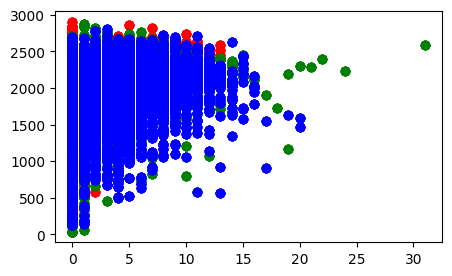

In [16]:
# Use scatter plot to show the correlation between eos count and terms count, unique bigram count
plt.figure(figsize=(5, 3))
for i, dataset in enumerate(datasets):
    plt.scatter(eos_count_dict[dataset], terms_count_dict[dataset], label=dataset, color=colors[i], alpha=0.5)